# Neutron reflectometry analysis of lipid monolayers

This notebook allows the co-refinement of different contrasts of lipid monolayers:

 - A model of 3 layers is used: tails | heads | protein
 - The possibility to include a guest molecule in heads and/or tails, a protein in this case, is implemented 
 - Constraint to make sure the the surface excess of heads and tails is the same in the monolayer is applied
 - The tails SLD is fitted in order to consider tail compaction and/or loss of molecules into the bulk

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path
import glob


import refnx, scipy

# the analysis module contains the curvefitting engine
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective, process_chain, Interval, Transform

# the reflect module contains functionality relevant to reflectometry
from refnx.reflect import SLD, ReflectModel, Structure, LipidLeaflet, Slab, create_occupancy

# the ReflectDataset object will contain the data
from refnx.dataset import ReflectDataset

# version numbers used in this analysis
refnx.version.version, scipy.version.version

('0.1.52', '1.14.1')

#### Loading the data

In [24]:
pth = os.getcwd()

data_dLip_acmw = ReflectDataset(os.path.join(pth, 'dLips_10SPC_ACMW_35.mft'))
data_dLip_acmw.name = "dLip_acmw"

data_dLip_d2o = ReflectDataset(os.path.join(pth, 'dLips_10SPC_D2O_35_checkpi.mft'))
data_dLip_d2o.name = "dLip_d2o"

# data_hLip_acmw = ReflectDataset(os.path.join(pth, 'hLips_10SPC_ACMW_35.mft'))
# data_hLip_acmw.name = "hLip_acmw"

data_hLip_d2o = ReflectDataset(os.path.join(pth, 'hLips_10SPC_D2O_35.mft'))
data_hLip_d2o.name = "hLip_d2o"


### Define all the necessary parameters to create the `structure` for each contrast:
Scattering lengths, molecular volume, SLD, roughness, thickness, volume fraction of solvent

In [25]:
air = SLD(0 + 0j, 'air')

# the following represent the solvent contrasts used in the experiment
d2o_hlip = SLD(6.15 + 0j, 'd2o_hlip')
d2o_dlip = SLD(6.15 + 0j, 'd2o_dlip')
acmw = SLD(0 + 0j, 'acmw')

#Define molecular volumes
vm_tail = Parameter(860.85, name="vm_tail")
vm_head = 327.1
vm_p = 500.53
vm_lip = vm_tail + vm_head


# Define scattering length (SL) of tails, heads, lipid molecule and protein
dtail_SL = 420.04
htail_SL = -16
d_head_d2o_SL = 95.74
d_head_acmw_SL = 85.78
h_head_d2o_SL = 84.16
h_head_acmw_SL = 74.69


d_lip_d2o_SL = dtail_SL + d_head_d2o_SL
d_lip_acmw_SL = dtail_SL + d_head_acmw_SL
h_lip_d2o_SL = htail_SL + h_head_d2o_SL
h_lip_acmw_SL = htail_SL + h_head_acmw_SL

spc_acmw_SLD = 1.28
spc_d2o_SLD = 2.14

#Define scattering length density (SLD)
d_lip_d2o_SLD = 10*d_lip_d2o_SL/vm_lip
d_lip_acmw_SLD = 10*d_lip_acmw_SL/vm_lip
h_lip_d2o_SLD = 10*h_lip_d2o_SL/vm_lip
h_lip_acmw_SLD = 10*h_lip_acmw_SL/vm_lip



rough = Parameter(value=3.9, name='rough', vary=False, bounds=Interval(lb=3.9, ub=6))

# Monolayer / tails layer
tail_thick = Parameter(value=13, name='tail_thick', vary=True, bounds=Interval(lb=10, ub=20))
htail_SLD = Parameter(value=10*htail_SL/vm_tail, name='htail_SLD', vary=True, bounds=Interval(lb=10*htail_SL/vm_tail, ub=1.5*10*htail_SL/vm_tail))
dtail_SLD = Parameter(value=10*dtail_SL/vm_tail, name='dtail_SLD', vary=True, bounds=Interval(lb=10*dtail_SL/vm_tail, ub=1.5*10*dtail_SL/vm_tail))
tail_vfsolv = Parameter(value=0.0, name='tail_vfsolv')

# Monolayer / headgroups layer
head_thick = Parameter(value=9, name='head_thick', vary=True, bounds=Interval(lb=5, ub=12))
d_head_d2o_SLD = Parameter(value=10*d_head_d2o_SL/vm_head, name='d_head_d2o_SLD')
d_head_acmw_SLD = Parameter(value=10*d_head_acmw_SL/vm_head, name='d_head_acmw_SLD')
h_head_d2o_SLD = Parameter(value=10*h_head_d2o_SL/vm_head, name='h_head_d2o_SLD')
# h_head_acmw_SLD = Parameter(value=10*h_head_acmw_SL/vm_head, name='h_head_acmw_SLD')
head_vfsolv = Parameter(value=0.35, name='head_vfsolv', vary=True, bounds=Interval(lb=0, ub=0.7))

# Monolayer / protein layer
spc_thick = Parameter(value=9, name='spc_thick', vary=True, bounds=Interval(lb=1, ub=10))
spc_vfsolv = Parameter(value=0.8, name='spc_vfsolv', vary=True, bounds=Interval(lb=0.1, ub=0.9))

# Based on the previously defined parameters, the slabs for the different contrasts are constructed
htail = Slab(tail_thick, htail_SLD, rough, 'tail', tail_vfsolv)
dtail = Slab(tail_thick, dtail_SLD, rough, 'dtail', tail_vfsolv)
d_head_d2o = Slab(head_thick, d_head_d2o_SLD, rough, 'head', head_vfsolv)
d_head_acmw = Slab(head_thick, d_head_acmw_SLD, rough, 'head', head_vfsolv)
h_head_d2o = Slab(head_thick, h_head_d2o_SLD, rough, 'head', head_vfsolv)
# h_head_acmw = Slab(head_thick, h_head_acmw_SLD, rough, 'head', head_vfsolv)
spc_acmw = Slab(spc_thick, spc_acmw_SLD, rough, 'spc_acmw', spc_vfsolv)
spc_d2o = Slab(spc_thick, spc_d2o_SLD, rough, 'spc_d2o', spc_vfsolv)

# backing_roughness = Parameter(4.5, 'backing_rough')

# The following parameters define the volume fraction of the protein in heads (p_heads_vf) and tails (p_tails_vf)
p_heads_vf = Parameter(value=0.0231, name='p_head_vfsolv', vary=False, bounds=Interval(lb=0.0, ub=1.0))
p_tails_vf = Parameter(value=0.0231, name='p_tails_vfsolv', vary=False, bounds=Interval(lb=0.0, ub=1.0))

# The surface excess and area per molecule of heads and tails in the monolayer and reservoirs is calculated
Gamma_tails_monolayer = (tail_thick*dtail_SLD*(1 - p_tails_vf))/(dtail_SL*0.06023)
Gamma_heads_monolayer = (head_thick*d_head_acmw_SLD*(1 - p_heads_vf - head_vfsolv))/(d_head_acmw_SL*0.06023)
A_permolecule_tails_monolayer = 10**20/(Gamma_tails_monolayer*10**-6*6.022*10**23)
A_permolecule_heads_monolayer =10**20/(Gamma_heads_monolayer*10**-6*6.022*10**23)

#### Define the constraints to be applied in the fit

In [26]:
# (1) The first constraint is ensuring that the surface excess of tails and heads in the monolayer is the same. The calculation is taking the account the
# amount of protein in heads and/or tails that must be defined previously as p_heads_vf and/or p_tails_vf
head_vfsolv.set_constraint(1 - p_heads_vf - ((tail_thick * ((d_head_acmw_SL * 0.06023 * dtail_SLD * (1 - p_tails_vf))))/(d_head_acmw_SLD * head_thick * 0.06023 * dtail_SL)))

def calculate_heads_vf():
    return 1 - head_vfsolv.value - p_heads_vf.value

heads_vf = Parameter(name='heads_vf')
heads_vf.set_constraint(calculate_heads_vf)

# (2) A second constraint need to fit the SLD of the deuterated tails and hydrogenous tails to variate in teh same way.
htail_SLD.set_constraint(
    10*htail_SL/(10*dtail_SL/dtail_SLD))

#### Define the `structure` of the different contrasts

In [27]:
dLip_acmw = air | dtail | d_head_acmw | spc_acmw | acmw(0, rough)
dLip_d2o = air | dtail | d_head_d2o | spc_d2o | d2o_dlip(0, rough)
# hLip_acmw = air | htail | h_head_acmw | spc_acmw | acmw(0, rough)
hLip_d2o = air | htail | h_head_d2o | spc_d2o | d2o_hlip(0, rough)

#### Create a `model` for each dataset based on the `structure` previously defined

In [28]:
scale = 1.0
bkg = 1e-6
name = 'model'
dq = 7

model_dLip_acmw = ReflectModel(dLip_acmw, scale, bkg, 'model_dLip_acmw', dq)
model_dLip_d2o = ReflectModel(dLip_d2o, 0.9859, 1e-07, 'model_dLip_d2o', dq)
# model_hLip_acmw = ReflectModel(hLip_acmw, scale, bkg, 'model_hLip_acmw', dq)
model_hLip_d2o = ReflectModel(hLip_d2o, 0.9585, 1e-06, 'model_hLip_d2o', dq)

#### Combine model and data into a `objective` for each contrast

In [29]:
YX4 = Transform('YX4')

objective_dLip_acmw = Objective(model_dLip_acmw, data_dLip_acmw, transform=YX4, name='dLip_acmw')
objective_dLip_d2o = Objective(model_dLip_d2o, data_dLip_d2o, transform=YX4, name='dLip_d2o')
# objective_hLip_acmw = Objective(model_hLip_acmw, data_hLip_acmw, transform=YX4, name='hLip_acmw')
objective_hLip_d2o = Objective(model_hLip_d2o, data_hLip_d2o, transform=YX4, name='hLip_d2o')

#### Combine multiple objectives into a `global objective` to corefine different contrasts

In [30]:
objective_dLip_acmw.weighted = objective_dLip_d2o.weighted = objective_hLip_d2o.weighted = True 
global_objective = GlobalObjective([objective_dLip_acmw, objective_dLip_d2o, objective_hLip_d2o])

#### Create and perform fitting routine

In [31]:
fitter = CurveFitter(global_objective)
fitter.fit(method = 'differential_evolution')

-5748.47946935101: : 21it [00:10,  1.96it/s]  


             message: Optimization terminated successfully.
             success: True
                 fun: -5755.563792922321
                   x: [ 1.247e+01  4.879e+00  7.170e+00  3.035e+00
                        1.000e-01]
                 nit: 21
                nfev: 1794
          population: [[ 1.249e+01  4.886e+00 ...  3.205e+00  1.815e-01]
                       [ 1.203e+01  4.942e+00 ...  5.661e+00  3.201e-01]
                       ...
                       [ 1.230e+01  4.897e+00 ...  3.945e+00  1.588e-01]
                       [ 1.240e+01  4.897e+00 ...  3.975e+00  3.009e-01]]
 population_energies: [-5.756e+03 -5.657e+03 ... -5.728e+03 -5.737e+03]
                 jac: [-3.638e-04  2.227e+02 -2.728e-04 -2.547e-03
                        1.472e+01]
               covar: [[ 4.439e-02 -1.458e-02 ...  4.603e-01  1.433e-01]
                       [-1.458e-02  4.859e-03 ... -1.579e-01 -4.889e-02]
                       ...
                       [ 4.603e-01 -1.579e-01 ...  

#### Print chi2 and a summary of the fitted paremeters

In [32]:
print(f"chi2: {global_objective.chisqr()/(global_objective.npoints - len(global_objective.varying_parameters()))}")
print(global_objective.parameters.varying_parameters())

chi2: 3.0547883325115004
________________________________________________________________________________
Parameters:      None      
<Parameter: 'tail_thick'  , value=12.4726 +/- 0.211, bounds=[10.0, 20.0]>
<Parameter:  'dtail_SLD'  , value=4.87936 +/- 0.0697, bounds=[4.8793634198757045, 7.319045129813556]>
<Parameter: 'head_thick'  , value=7.17026 +/- 0.796, bounds=[5.0, 12.0]>
<Parameter:  'spc_thick'  , value=3.03499 +/- 3.03 , bounds=[1.0, 10.0]>
<Parameter: 'spc_vfsolv'  , value=0.1 +/- 0.913, bounds=[0.1, 0.9]>


##### Print summary of the most relevant parameters

In [33]:
print(f"chi2: {global_objective.chisqr()/(global_objective.npoints - len(global_objective.varying_parameters()))}")
print()
print(tail_thick)
print(p_tails_vf)
print(dtail_SLD)
print(f"dtail_SLD: {dtail_SLD.value}")
print(f"htail_SLD: {dtail_SLD.value}")
print(f"Delta %SLD: {100*(dtail_SLD.value-4.87)/4.87}")
print()
print(head_thick)
print(head_vfsolv)
print(p_heads_vf)
print(rough)
print()
print(spc_thick)
print(spc_vfsolv)
print()
print(f"Gamma_tails_monolayer: {Gamma_tails_monolayer.value}")
print(f"Gamma_heads_monolayer: {Gamma_heads_monolayer.value}")
print(f"A_permolecule_tails_monolayer: {A_permolecule_tails_monolayer.value}")
print(f"A_permolecule_heads_monolayer: {A_permolecule_heads_monolayer.value}")
print()

chi2: 3.0547883325115004

<Parameter: 'tail_thick'  , value=12.4726 +/- 0.211, bounds=[10.0, 20.0]>
<Parameter:'p_tails_vfsolv', value=0.0231  (fixed) , bounds=[0.0, 1.0]>
<Parameter:  'dtail_SLD'  , value=4.87936 +/- 0.0697, bounds=[4.8793634198757045, 7.319045129813556]>
dtail_SLD: 4.8793634198757045
htail_SLD: 4.8793634198757045
Delta %SLD: 0.19226734857709316

<Parameter: 'head_thick'  , value=7.17026 +/- 0.796, bounds=[5.0, 12.0]>
<Parameter: 'head_vfsolv' , value=0.33121          , bounds=[0.0, 0.7], constraint=<Parameter:     None      , value=0.33121  (fixed) , bounds=None>>
<Parameter:'p_head_vfsolv', value=0.0231  (fixed) , bounds=[0.0, 1.0]>
<Parameter:    'rough'    , value=3.9  (fixed) , bounds=[3.9, 6.0]>

<Parameter:  'spc_thick'  , value=3.03499 +/- 3.03 , bounds=[1.0, 10.0]>
<Parameter: 'spc_vfsolv'  , value=0.1 +/- 0.913, bounds=[0.1, 0.9]>

Gamma_tails_monolayer: 2.3499854104910924
Gamma_heads_monolayer: 2.349985410491093
A_permolecule_tails_monolayer: 70.66332725681

#### Vertification of applied constraints

In [34]:
# Verify that the constraints are correctly applied across all contrasts

# Constraint [Gamma_tails_monolayer = Gamma_heads_monolayer]
print(f"Gamma_heads_monolayer_d_acmw: {(head_thick*d_head_acmw_SLD*(1 - p_heads_vf - head_vfsolv))/(d_head_acmw_SL*0.06023)}")
print(f"Gamma_tails_monolayer_d_acmw: {(tail_thick*dtail_SLD*(1 - p_tails_vf))/(dtail_SL*0.06023)}")
print()
print(f"Gamma_heads_monolayer_d_d2o: {(head_thick*d_head_d2o_SLD*(1 - p_heads_vf - head_vfsolv))/(d_head_d2o_SL*0.06023)}")
print(f"Gamma_tails_monolayer_d_d2o: {(tail_thick*dtail_SLD*(1 - p_tails_vf))/(dtail_SL*0.06023)}")
print()
# print(f"Gamma_heads_monolayer_h_acmw: {(head_thick*h_head_acmw_SLD*(1 - p_heads_vf - head_vfsolv))/(h_head_acmw_SL*0.06023)}")
# print(f"Gamma_tails_monolayer_h_acmw: {(tail_thick*htail_SLD*(1 - p_tails_vf))/(htail_SL*0.06023)}")
# print()
print(f"Gamma_heads_monolayer_h_d2o: {(head_thick*h_head_d2o_SLD*(1 - p_heads_vf - head_vfsolv))/(h_head_d2o_SL*0.06023)}")
print(f"Gamma_tails_monolayer_h_d2o: {(tail_thick*htail_SLD*(1 - p_tails_vf))/(htail_SL*0.06023)}")
print()

Gamma_heads_monolayer_d_acmw: <Parameter:     None      , value=2.34999  (fixed) , bounds=None>
Gamma_tails_monolayer_d_acmw: <Parameter:     None      , value=2.34999  (fixed) , bounds=None>

Gamma_heads_monolayer_d_d2o: <Parameter:     None      , value=2.34999  (fixed) , bounds=None>
Gamma_tails_monolayer_d_d2o: <Parameter:     None      , value=2.34999  (fixed) , bounds=None>

Gamma_heads_monolayer_h_d2o: <Parameter:     None      , value=2.34999  (fixed) , bounds=None>
Gamma_tails_monolayer_h_d2o: <Parameter:     None      , value=2.34999  (fixed) , bounds=None>



#### Plot the refletivity profiles and the obtained fits

C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_24592\1761923138.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_24592\1761923138.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')


chi2: 3.0547883325115004


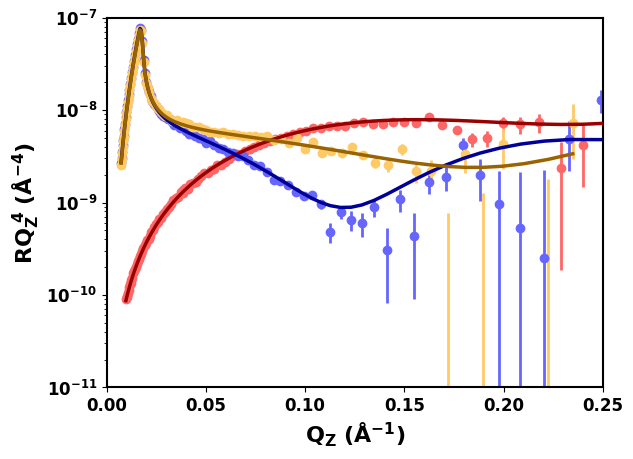

In [35]:
print(f"chi2: {global_objective.chisqr()/(global_objective.npoints - len(global_objective.varying_parameters()))}")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import colorsys


# Plot using refnx built-in function
fig, ax = global_objective.plot()

# Set axis line thickness
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# Font size and bold labels
ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')

# Axis formatting
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$")
)

# Axes scaling and limits
ax.set_yscale('log')
ax.set_xlabel(r'$\mathbf{Q}_\mathbf{Z}$ $\mathbf{(\AA}^{\mathbf{-1}}\mathbf{)}$', fontsize=16)
ax.set_ylabel(r'$\mathbf{RQ}_{\mathbf{Z}}^{\ \mathbf{4}}$ $\mathbf{(\AA}^{\mathbf{-4}}\mathbf{)}$', fontsize=16)
ax.set_xlim(0, 0.25)
ax.set_ylim(1E-11, 1E-7)

def adjust_color_lightness(color, factor):
    """Adjust lightness of a matplotlib color using HLS."""
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = np.clip(l * factor, 0, 1)
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b)

light_red = adjust_color_lightness('red', 1.4)    # lighter red
dark_red  = adjust_color_lightness('red', 0.6)    # darker red
light_blue = adjust_color_lightness('blue', 1.4)
dark_blue  = adjust_color_lightness('blue', 0.6)
light_orange = adjust_color_lightness('orange', 1.4)
dark_orange  = adjust_color_lightness('orange', 0.6)

# === Define custom colors for datasets === #
data_styles = {
    'dLip_acmw': {'color': light_red, 'line': dark_red},
    'dLip_d2o': {'color': light_blue, 'line': dark_blue},
    'hLip_d2o': {'color': light_orange, 'line': dark_orange},
}

# === Apply custom styles to data and fit lines === #
lines = ax.get_lines()
line_idx = 0

for objective in global_objective.objectives:
    label = objective.data.name
    if label not in data_styles:
        continue

    # --- Data line (markers) ---
    data_line = lines[line_idx]
    data_line.set_color(data_styles[label]['color'])
    data_line.set_marker('o')
    data_line.set_markersize(6)
    data_line.set_linestyle('None')
    data_line.set_label(label)  # For legend

    line_idx += 1

    # --- Fit line ---
    fit_line = lines[line_idx]
    fit_line.set_color(data_styles[label]['line'])
    fit_line.set_linewidth(2.5)
    fit_line.set_label(f"{label} fit")

    line_idx += 1

# === Fix error bar colors to match data points === #
# ax.collections are the error bars
for col, objective in zip(ax.collections, global_objective.objectives):
    label = objective.data.name
    if label in data_styles:
        col.set_color(data_styles[label]['color'])

# === Add legend === #
# ax.legend(frameon=True, prop={'weight': 'bold', 'size': 10})

# === Optional: Save figure for publication === #
fig.savefig("Ref_fit_SPC_35mNm.png", dpi=600, bbox_inches='tight')

#### Plot SLD profiles

C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_24592\2614027390.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_24592\2614027390.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')


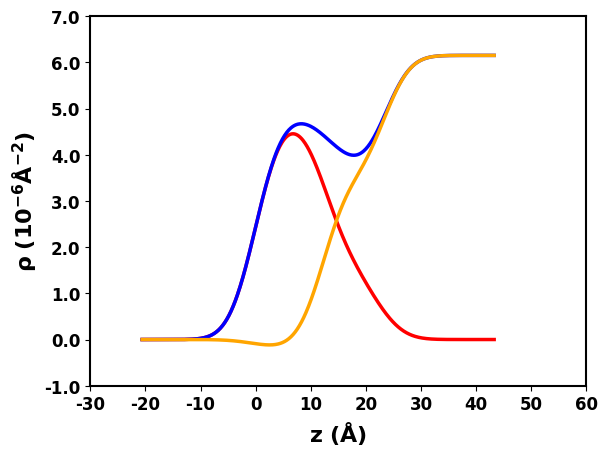

In [36]:
fig, ax = plt.subplots()

ax = plt.gca()  # Get the current axis

# Set the thickness of each axis line
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
import matplotlib.pyplot as plt

# Set the size of the x and y labels
ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')

# To round the values of x-axis to two decimal places
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

def adjust_color_lightness(color, factor):
    """Adjust lightness of a matplotlib color using HLS."""
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = np.clip(l * factor, 0, 1)
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b)

dark_red  = adjust_color_lightness('red', 0.6)    # darker red
dark_blue  = adjust_color_lightness('blue', 0.6)
dark_orange  = adjust_color_lightness('orange', 0.6)

ax.plot(*dLip_acmw.sld_profile(), label='dLip_acmw', color='red', linewidth=2.5)
ax.plot(*dLip_d2o.sld_profile(), label='dLip_d2o', color='blue', linewidth=2.5)
# ax.plot(*hLip_acmw.sld_profile(), label='hLip_acmw', color='green', linewidth=2.5)
ax.plot(*hLip_d2o.sld_profile(), label='hLip_d2o', color='orange', linewidth=2.5)

ax.set_ylabel(r"$\mathbf{\rho}$ $\mathbf{(10}^{\mathbf{-6}} \mathbf{\AA}^{\mathbf{-2}}\mathbf{)}$", fontsize=16)
ax.set_xlabel(r"$\mathbf{z}$ $\mathbf{(\AA)}$", fontsize=16)
plt.xlim(-30, 60)
plt.ylim(-1, 7)
# ax.legend(frameon=True, prop={'weight': 'bold', 'size': 10});

fig.savefig("SLDprofile_SPC_35mNm.png", dpi=600, bbox_inches='tight')

#### Generate and plot the volume fraction profiles

C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_24592\1637114662.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_24592\1637114662.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')


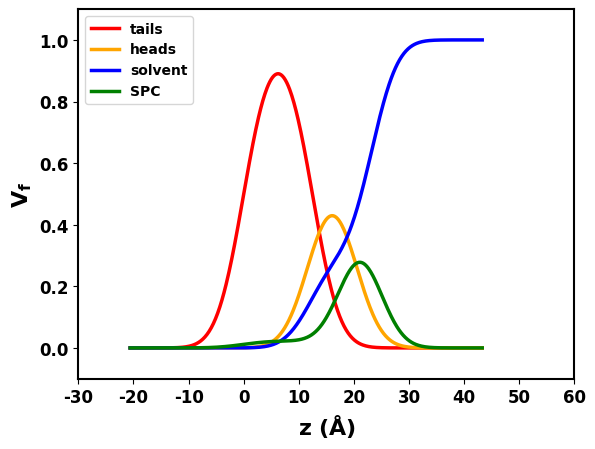

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Define custom colors
color_map = {
    "tails": "red",
    "heads": "orange",
    "SPC": "green",
    "solvent": "blue",
}

# Generate z and volume fraction profiles
z, vfps = create_occupancy(dLip_acmw)

# Create plot
fig, ax = plt.subplots()

# Set axis line thickness
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# Set tick label font size and weight
ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')

# Format tick labels
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# Plot tails, heads, and solvent
groups = [(1,), (2,), (4,)]
labels = ["tails", "heads", "solvent"]

for g, label in zip(groups, labels):
    vfp = np.take(vfps, g, axis=0)
    if len(vfp.shape) > 1:
        vfp = np.sum(vfp, axis=0)
    ax.plot(z, vfp, label=label, linewidth=2.5, color=color_map[label])

# Plot SPC separately: 10% of layers 1 and 2, 100% of layer 3
vfp_spc = 0.0231 * vfps[1] + 0.0231 * vfps[2] + vfps[3]
ax.plot(z, vfp_spc, label="SPC", linewidth=2.5, color=color_map["SPC"])

# Final plot settings
ax.legend(frameon=True, prop={'weight': 'bold', 'size': 10})
ax.set_ylabel(r'$\mathbf{V}_\mathbf{f}$', fontsize=16)
ax.set_xlabel(r"$\mathbf{z}$ $\mathbf{(\AA)}$", fontsize=16)
ax.set_xlim(-30, 60)
ax.set_ylim(-0.1, 1.1)

plt.show()
fig.savefig("Vfprofile_SPC_35mNm.png", dpi=600, bbox_inches='tight')

C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_24592\1132320053.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_24592\1132320053.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')


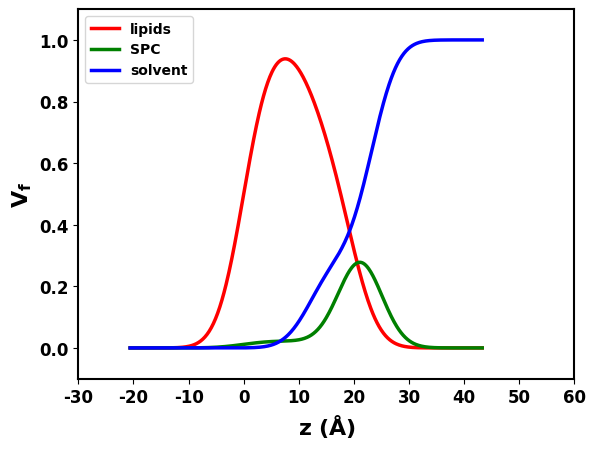

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Define custom colors
color_map = {
    "lipids": "red",
    "SPC": "green",
    "solvent": "blue",
}

# Generate z and volume fraction profiles
z, vfps = create_occupancy(dLip_acmw)

# Create plot
fig, ax = plt.subplots()

# Set axis line thickness
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# Set tick label font size and weight
ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')

# Format tick labels
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# Plot combined lipid profile (heads + tails)
vfp_lipids = vfps[1] + vfps[2]
ax.plot(z, vfp_lipids, label="lipids", linewidth=2.5, color=color_map["lipids"])

# Plot SPC: 10% of layers 1 and 2 + 100% of layer 3
vfp_spc = 0.0231 * vfps[1] + 0.0231 * vfps[2] + vfps[3]
ax.plot(z, vfp_spc, label="SPC", linewidth=2.5, color=color_map["SPC"])

# Plot solvent
vfp_solvent = vfps[4]
ax.plot(z, vfp_solvent, label="solvent", linewidth=2.5, color=color_map["solvent"])

# Final plot settings
ax.legend(frameon=True, prop={'weight': 'bold', 'size': 10})
ax.set_ylabel(r'$\mathbf{V}_\mathbf{f}$', fontsize=16)
ax.set_xlabel(r"$\mathbf{z}$ $\mathbf{(\AA)}$", fontsize=16)
ax.set_xlim(-30, 60)
ax.set_ylim(-0.1, 1.1)

plt.show()


#### Perform MCMC analysis

In [39]:
fitter.reset()
fitter.sample(100, pool=1)
fitter.reset()

100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


In [40]:
res = fitter.sample(100, nthin=10, pool=1)

100%|██████████| 1000/1000 [16:36<00:00,  1.00it/s]


#### List of parameters of the Global Objective

In [41]:
print(global_objective)

________________________________________________________________________________


--Global Objective--
________________________________________________________________________________
Objective - dLip_acmw
Dataset = dLip_acmw
datapoints = 99
chi2 = 196.50276838607644
Weighted = True
Transform = Transform('YX4')
________________________________________________________________________________
Parameters: 'model_dLip_acmw'
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=1  (fixed) , bounds=[-inf, inf]>
<Parameter:     'bkg'     , value=1e-06  (fixed) , bounds=[-inf, inf]>
<Parameter:'dq - resolution', value=7  (fixed) , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
___________________________________________________________________________

In [43]:
print(f"chi2: {global_objective.chisqr()/(global_objective.npoints - len(global_objective.varying_parameters()))}")
print(global_objective.parameters.varying_parameters())

chi2: 3.064959984403771
________________________________________________________________________________
Parameters:      None      
<Parameter: 'tail_thick'  , value=12.4588 +/- 0.0284, bounds=[10.0, 20.0]>
<Parameter:  'dtail_SLD'  , value=4.88257 +/- 0.00392, bounds=[4.8793634198757045, 7.319045129813556]>
<Parameter: 'head_thick'  , value=7.11007 +/- 0.165, bounds=[5.0, 12.0]>
<Parameter:  'spc_thick'  , value=3.21021 +/- 0.208, bounds=[1.0, 10.0]>
<Parameter: 'spc_vfsolv'  , value=0.142647 +/- 0.0473, bounds=[0.1, 0.9]>


In [44]:
print(f"chi2: {global_objective.chisqr()/(global_objective.npoints - len(global_objective.varying_parameters()))}")
print()
print(tail_thick)
print(p_tails_vf)
print(dtail_SLD)
print(f"dtail_SLD: {dtail_SLD.value}")
print(f"htail_SLD: {dtail_SLD.value}")
print(f"Delta %SLD: {100*(dtail_SLD.value-4.87)/4.87}")
print()
print(head_thick)
print(head_vfsolv)
print(p_heads_vf)
print(rough)
print()
print(spc_thick)
print(spc_vfsolv)
print()
print(f"Gamma_tails_monolayer: {Gamma_tails_monolayer.value}")
print(f"Gamma_heads_monolayer: {Gamma_heads_monolayer.value}")
print(f"A_permolecule_tails_monolayer: {A_permolecule_tails_monolayer.value}")
print(f"A_permolecule_heads_monolayer: {A_permolecule_heads_monolayer.value}")
print()

chi2: 3.064959984403771

<Parameter: 'tail_thick'  , value=12.4588 +/- 0.0284, bounds=[10.0, 20.0]>
<Parameter:'p_tails_vfsolv', value=0.0231  (fixed) , bounds=[0.0, 1.0]>
<Parameter:  'dtail_SLD'  , value=4.88257 +/- 0.00392, bounds=[4.8793634198757045, 7.319045129813556]>
dtail_SLD: 4.882574615987312
htail_SLD: 4.882574615987312
Delta %SLD: 0.25820566709058906

<Parameter: 'head_thick'  , value=7.11007 +/- 0.165, bounds=[5.0, 12.0]>
<Parameter: 'head_vfsolv' , value=0.326034 +/- 0.0141, bounds=[0.0, 0.7], constraint=<Parameter:     None      , value=0.326034  (fixed) , bounds=None>>
<Parameter:'p_head_vfsolv', value=0.0231  (fixed) , bounds=[0.0, 1.0]>
<Parameter:    'rough'    , value=3.9  (fixed) , bounds=[3.9, 6.0]>

<Parameter:  'spc_thick'  , value=3.21021 +/- 0.208, bounds=[1.0, 10.0]>
<Parameter: 'spc_vfsolv'  , value=0.142647 +/- 0.0473, bounds=[0.1, 0.9]>

Gamma_tails_monolayer: 2.3489378682175244
Gamma_heads_monolayer: 2.3489378682175244
A_permolecule_tails_monolayer: 70.69